# Petrillo & Sacchetti data treatment

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sci
from scipy.optimize import curve_fit
from pathlib import Path

import os
 
# change the current directory
# to specified directory
os.chdir(r"/home/simo/Scrivania/Thesis/Data")

Define functions

In [2]:
def get_indices_in_range(lst, start, end):
    """
    Returns a new list containing only the indices of the values within the given range (inclusive).
    """
    return [i for i, x in enumerate(lst) if start <= x <= end]

def remove_indexes(my_list, indexes_to_remove):
    return [x for i, x in enumerate(my_list) if i not in indexes_to_remove]

def read_dat_file(filename,skip):
    data = np.loadtxt(filename+'.dat',skiprows= skip,encoding='unicode_escape') #utf-8-sig')
    col = []
    num = len(data.transpose())
    for i in range(num):
        if num == len(data):
            col1 = data[i]
        else:
            col1 = data[:,i]
        col.append(col1)

    return col

def gaussian(x, a, x0, sigma):
    """
    Gaussian function with amplitude a, mean x0, and standard deviation sigma.
    """
    return a * np.exp(-(x - x0)**2/ (2 * sigma**2))

def gaussian_baseline(x, a, x0, sigma,b):
    """
    Gaussian function with amplitude a, mean x0, and standard deviation sigma.
    """
    return a * np.exp(-(x - x0)**2/ (2 * sigma**2)) + b

def gaussian_zero(x, a, sigma,b):
    """
    Gaussian function with amplitude a, mean x0, and standard deviation sigma.
    """
    return a * np.exp(-x**2/ (2 * sigma**2)) + b


def gaussian_sum(x, *params):
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        amp, cen, wid = params[i:i+3]
        y = y + amp * np.exp(-(x-cen)**2 / (2*wid**2))
    return y


def my_round(x,dx):      # per avere dato + errore con le giuste cire significative (incertezza con una sola cifra significativa)  ---> da sistemare,quando dx salta di cifra x resta arrotondato a cifra sotto
    round_x = []
    if np.size(x) > 1:
        for i in range(np.size(x)):
            if dx[i] < 1:
                dist = -int(np.log10(dx[i])-1)
                dx_new =  round(dx[i],dist)
                x_new = round(x[i],-int(np.log10(dx_new)-1))
            else:
                dist = -int(np.log10(dx[i]))
                dx_new =  round(dx[i],dist)
                x_new = round(x[i],-int(np.log10(dx_new)))
            round_x.append([x_new,dx_new])
    else:
            if dx < 1:
                dist = -int(np.log10(dx)-1)
                dx_new =  round(dx,dist)
                x_new = round(x,-int(np.log10(dx_new)-1))
            else:
                dist = -int(np.log10(dx))
                dx_new =  round(dx,dist)
                x_new = round(x,-int(np.log10(dx_new)))
            round_x.append([x_new, dx_new])
    return round_x

# Import data

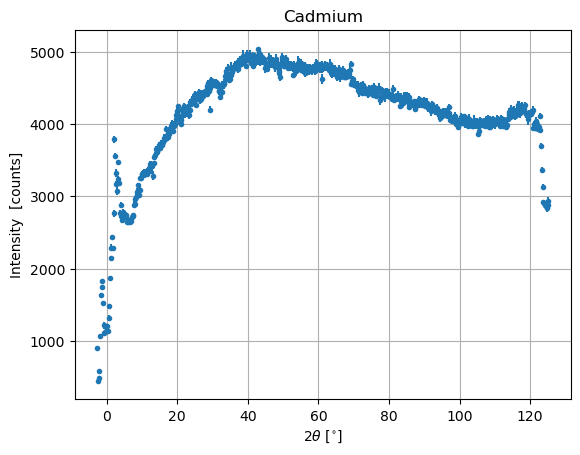

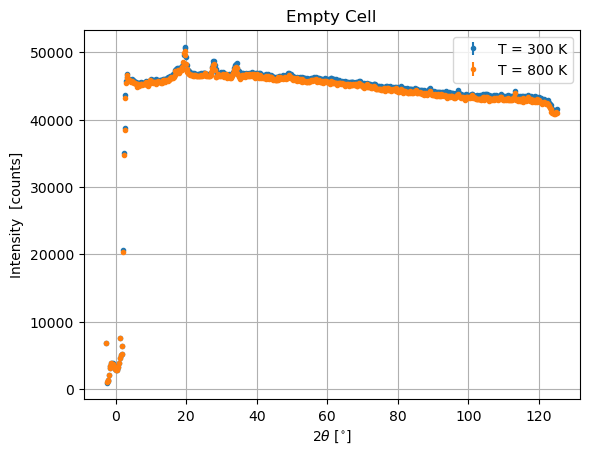

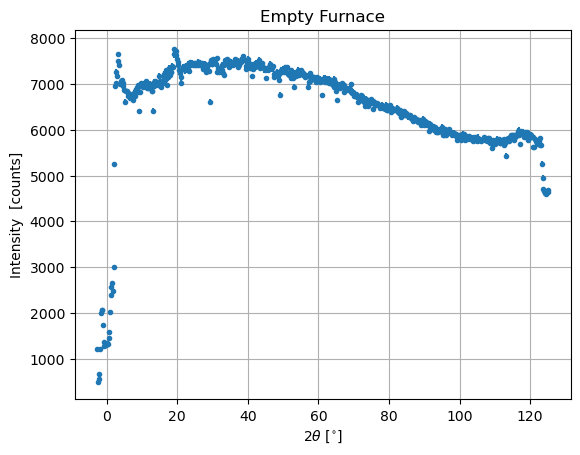

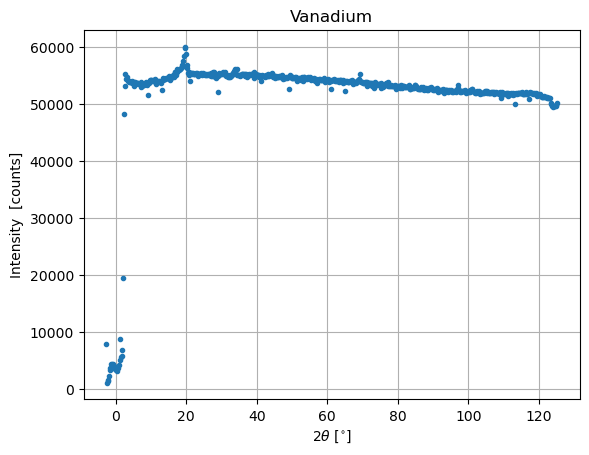

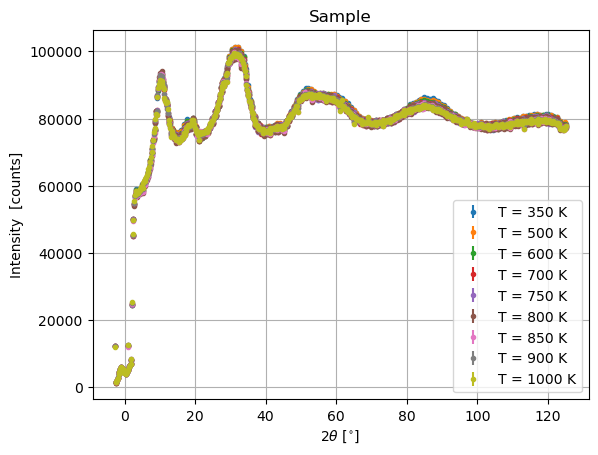

In [3]:
angle = read_dat_file('cadmium',1)[0]
err_angle = read_dat_file('calibration',1)[1][0]
lamda = read_dat_file('calibration_parameters',1)[2]
err_lamda = read_dat_file('calibration_parameters',1)[3]
err_theta0 = read_dat_file('calibration_parameters',1)[1]
q = 4*np.pi*np.sin(angle*np.pi/360)/lamda   # in Angstrom inversi
err_q = abs(q)*np.sqrt((err_lamda/lamda)**2+(err_theta0*np.pi/360/np.tan(angle*np.pi/360))**2)

cadmium = read_dat_file('cadmium',1)[1]
err_cadmium = read_dat_file('cadmium',1)[2]

plt.errorbar(angle,cadmium, fmt = '.', yerr = err_cadmium)
plt.xlabel(r'$2 \theta$ [$^{\circ}$]')
plt.ylabel('Intensity  [counts]')
plt.title('Cadmium')
plt.grid()
plt.show()

empty_cell_300K = read_dat_file('empty_cell_300K',1)[1]
err_empty_cell_300K = read_dat_file('empty_cell_300K',1)[2]

empty_cell_800K = read_dat_file('empty_cell_800K',1)[1]
err_empty_cell_800K = read_dat_file('empty_cell_800K',1)[2]

plt.errorbar(angle,empty_cell_300K, fmt = '.', yerr = err_empty_cell_300K, label ='T = 300 K')
plt.errorbar(angle,empty_cell_800K, fmt = '.', yerr = err_empty_cell_800K, label ='T = 800 K')
plt.xlabel(r'$2 \theta$ [$^{\circ}$]')
plt.ylabel('Intensity  [counts]')
plt.title('Empty Cell')
plt.legend()
plt.grid()
plt.show()

empty_furnace = read_dat_file('empty_furnace',1)[1]
err_empty_furnace = read_dat_file('empty_furnace',1)[2]

plt.errorbar(angle,empty_furnace, fmt = '.', yerr = err_empty_furnace)
plt.xlabel(r'$2 \theta$ [$^{\circ}$]')
plt.ylabel('Intensity  [counts]')
plt.title('Empty Furnace')
plt.grid()
plt.show()

vanadium = read_dat_file('vanadium',1)[1]
err_vanadium = read_dat_file('vanadium',1)[2]

plt.errorbar(angle,vanadium, fmt = '.', yerr = err_vanadium)
plt.xlabel(r'$2 \theta$ [$^{\circ}$]')
plt.ylabel('Intensity  [counts]')
plt.title('Vanadium')
plt.grid()
plt.show()

T = [350, 500, 600, 700, 750, 800, 850, 900, 1000]
sample = []
err_sample = []

for i in range(len(T)):
    name = 'sample_' + str(T[i]) + 'K'
    data = read_dat_file(name,1)[1]
    err_data = read_dat_file(name,1)[2]

    sample.append(data)
    err_sample.append(err_data)

    plt.errorbar(angle,data, fmt = '.', yerr = err_data ,label = 'T = %d K' %T[i])
plt.xlabel(r'$2 \theta$ [$^{\circ}$]')
plt.ylabel('Intensity  [counts]')
plt.title('Sample')
plt.grid()
plt.legend()
plt.show()

# Background intensities

Retrieve $\mu_{tot}$ of V and $GeO_2$ to give input the Trasb.f code.

In [4]:
def lin_fit(x,a,b):
    return a*x+b

# $GeO_2$

##### Extrapolation of maass density of GeO2 #####
Slope: -0.00018173345759552682 (g/cm^3)/K 
Intercept 3.714520037278658 g/cm^3


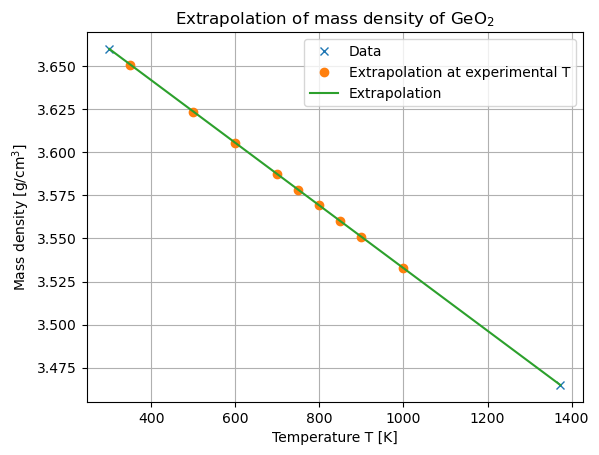

In [5]:
# Retrieve density of GeO2 at different T
#T = np.array([350, 500, 600, 700, 750, 800, 850, 900, 1000, 1100, 1200, 1300, 1325, 1350, 1400])  # K
T = np.array(T)
T_data = [300, 1373] #K
density = [3.66, 3.465]  # g/cm^3

slope = (density[0]-density[1])/(T_data[0]-T_data[1])
intercept = (T_data[1]*density[0]-T_data[0]*density[1])/(T_data[1]-T_data[0])
print('##### Extrapolation of maass density of GeO2 #####')
print('Slope:', slope,'(g/cm^3)/K \nIntercept',intercept,'g/cm^3')

density_geo2 = lin_fit(T,*[slope,intercept])

T_plot = np.linspace(min(T_data),max(T_data),10000)
plt.plot(T_data,density,'x',label = 'Data')
plt.plot(T[:],density_geo2[:],'o',label = 'Extrapolation at experimental T')
plt.plot(T_plot,lin_fit(T_plot,*[slope,intercept]), '-', label = 'Extrapolation')
plt.legend()
plt.grid()
plt.xlabel('Temperature T [K]')
plt.ylabel(r'Mass density [g/cm$^3$]')
plt.title(r'Extrapolation of mass density of GeO$_2$')
plt.show()

# $V$
Method and parameters value from "Zhang, Li and Li, Assessment of thermal expansion coefficient for pure metals"
Retrieve V density at different T: use thermal expansion coefficient $\beta = \frac{1}{V}\left(\frac{\partial V}{\partial T}\right)_P$. One writes $\beta$ as
$$
\beta = \frac{C_V}{Q_0\left[1-k\left(U/Q_0\right)\right]^2}
$$
where $C_V$ is the molar heat capacity at constant volume, $U$ is the energy of the lattice vibrations, and $Q_0$ and $k$ are constants. If the Debye temperature $\theta_D$ is known, both $C_V$ and $U$ may be calculated at any temperature $T$ from the equations
$$
C_V = 3 R \left[12\left(\frac{T}{\theta_D}\right)^3\int_0^{\theta_D/T}\frac{y^3}{\exp{y}-1}dy - 3 \frac{\theta_D/T}{\exp{\theta_D/T}-1}\right]
$$
$$
U = \int_0^T C_V dT
$$

Then one retireves the mass density from
$$
\frac{\Delta \rho}{\rho} = \exp\left(\int_{T_0}^{T_f}\beta(T) dT\right) - 1 \qquad \rho(T_f) = \rho_0\left(2-\exp\left(\int_{T_0}^{T_f}\beta(T) dT\right) \right)
$$
were $T_0 = 293$ K and $\rho_0 = \rho(T_0) = 6.099$ $g/cm^3$.

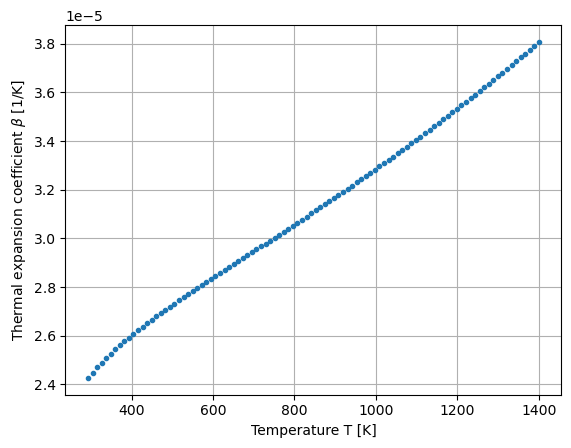

In [6]:
#parameters
k = 5.9149
Q0 = 946.3259 # kJ/mol
theta_d = 380 #K
R = 8.314e-3 # kJ/mol K

T_integ = np.linspace(293,1400,100)
Cv = np.zeros(len(T_integ))
U = np.zeros(len(T_integ))

for i in range(len(T_integ)):
    y = np.linspace(0.01, theta_d/T_integ[i],10000)
    integ = y**3/(np.exp(y)-1)
    cv = sci.integrate.simpson(integ, y)
    cv = 12*(T_integ[i]/theta_d)**3*cv - 3*(theta_d/T_integ[i])/(np.exp(theta_d/T_integ[i])-1)
    Cv[i]= 3*R*cv  # kJ/ mol K

for i in range(len(T_integ)):   
    u = sci.integrate.simpson(Cv[0:i+1],T_integ[0:i+1])
    U[i] = u  # kJ/ mol

beta = Cv/(Q0*(1-k*U/Q0)**2) # 1/K

plt.plot(T_integ,beta,'.')
plt.grid()
plt.xlabel('Temperature T [K]')
plt.ylabel(r'Thermal expansion coefficient $\beta$ [1/K]')
plt.show()

Retrieve $\rho_v$ at different temperatures

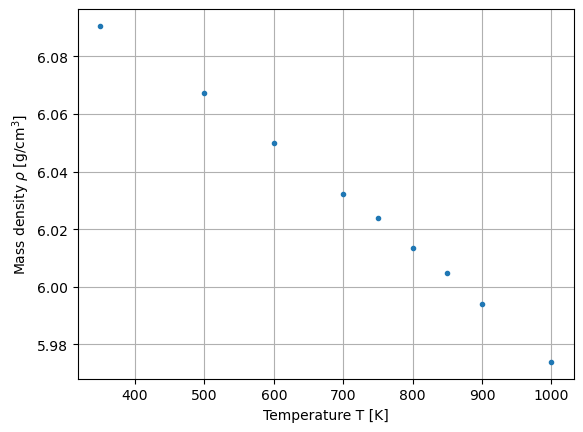

350 6.0905418544781105
500 6.067166884745838
600 6.050011066245077
700 6.032118134750729
750 6.0239306044664485
800 6.013490623987097
850 6.0049720091374255
900 5.994111738429804
1000 5.973953407601089


In [7]:
density_v_T0 = 6.099 # g/cm^3 @ 293 K
T0 = 293 #K

integ = np.zeros(len(T))

for i in range(len(T)):
    index = get_indices_in_range(T_integ,293, T[i])
    integ[i] = sci.integrate.simpson(beta[index],T_integ[index])

density_v = density_v_T0*(2-np.exp(integ))

plt.plot(T,density_v,'.')
plt.grid()
plt.xlabel('Temperature T [K]')
plt.ylabel(r'Mass density $\rho$ [g/cm$^3$]')
plt.show()

for i in range(len(T)):
    print(T[i],density_v[i])

Finally retrieve the $\mu_{tot} = \sum_i n_i \sigma_{tot,i}$. With $\sigma_{tot} = \sigma_a + \sigma_s$ in barn and $n$ in atoms/$\AA^3$, then $\mu_{tot}$ is in $cm^{-1}$, the index $i$ runs on the atomic species in the sample.

######### V #########
Number density V [0.07199875 0.07172242 0.07151962 0.0713081  0.07121131 0.0710879
 0.07098719 0.07085881 0.07062051] atoms/A^3
Total cross section V 7.159688542825361 barn


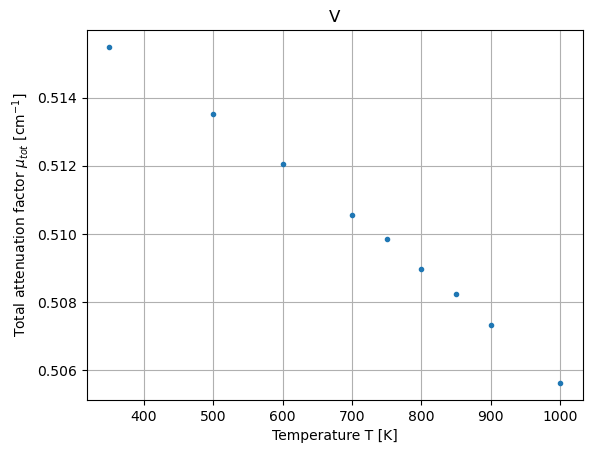

######### GeO2 #########
Number density  [0.02101314 0.02085625 0.02075165 0.02064705 0.02059475 0.02054245
 0.02049015 0.02043785 0.02033326] molecules/A^3
2.0596885428253615
17.064


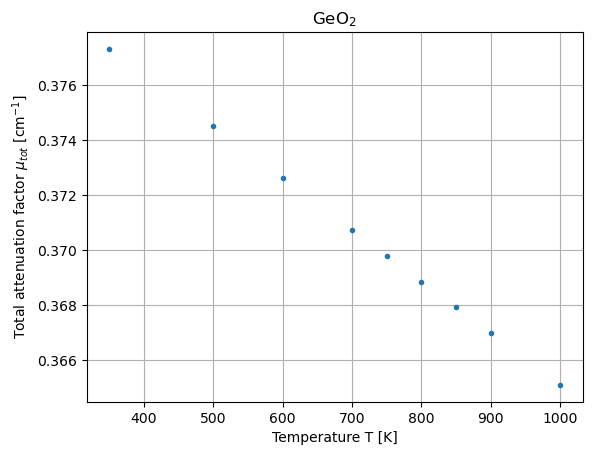

################# T = 350 K #################
mu_v =  0.5155 cm^-1     mu_geo2 = 0.3773 cm^-1
################# T = 500 K #################
mu_v =  0.5135 cm^-1     mu_geo2 = 0.3745 cm^-1
################# T = 600 K #################
mu_v =  0.5121 cm^-1     mu_geo2 = 0.3726 cm^-1
################# T = 700 K #################
mu_v =  0.5105 cm^-1     mu_geo2 = 0.3707 cm^-1
################# T = 750 K #################
mu_v =  0.5099 cm^-1     mu_geo2 = 0.3698 cm^-1
################# T = 800 K #################
mu_v =  0.509 cm^-1     mu_geo2 = 0.3689 cm^-1
################# T = 850 K #################
mu_v =  0.5082 cm^-1     mu_geo2 = 0.3679 cm^-1
################# T = 900 K #################
mu_v =  0.5073 cm^-1     mu_geo2 = 0.367 cm^-1
################# T = 1000 K #################
mu_v =  0.5056 cm^-1     mu_geo2 = 0.3651 cm^-1


In [8]:
N = 6.022e23   #avogadro number
lamda = 0.729

print('######### V #########')
#density_v = 6.099 # g/cm^3
aw_v = 50.9415   #g/mol
n_v = density_v*N/aw_v*1e-24  # atoms/A^3
print('Number density V',n_v,'atoms/A^3')

sigma_v_s = 5.10   # sigma_s in barn
sigma_v_a = 5.08*lamda/1.798  # divide by lambda corresponding to 25.3 meV to consider energy dependence of absorbivity cross section

sigma_v_tot = sigma_v_a + sigma_v_s
print('Total cross section V',sigma_v_tot,'barn')

mu_v = n_v*sigma_v_tot


#print('Total attenuation factor V',mu_v,'cm^-1')

plt.plot(T,mu_v,'.')
plt.grid()
plt.xlabel('Temperature T [K]')
plt.ylabel(r'Total attenuation factor $\mu_{tot}$ [cm$^{-1}$]')
plt.title('V')
plt.show()

print('######### GeO2 #########')
#density_geo2 = 3.66 #g/cm^3 at room T
aw_ge = 72.63 #g/mol
aw_o = 15.9994 #g/mol
aw_geo2 = aw_ge + 2*aw_o #g/mol

w_ge = aw_ge/aw_geo2
w_o = 2*aw_o/aw_geo2

n_ge =  density_geo2*N*w_ge/aw_ge*1e-24
n_o =  density_geo2*N*w_o/aw_o*1e-24
n_geo2 = density_geo2*N/aw_geo2*1e-24  # atoms/A^3

print('Number density ',n_geo2,'molecules/A^3')

#sum of atomic mu
sigma_ge_coh = 8.42
sigma_ge_inc = 0.18 
sigma_ge_a = 2.2*lamda/1.798
sigma_o_coh = 4.232
sigma_o_a = 0.000198*lamda/1.798

sigma_geo2_coh = sigma_ge_coh+2*sigma_o_coh

mu_o = n_o*(sigma_o_coh+sigma_o_a)
mu_ge = n_ge*(sigma_ge_coh+sigma_ge_inc+sigma_ge_a)

mu_geo2=mu_ge+mu_o

print(sigma_v_a)
print(sigma_geo2_coh+sigma_ge_inc)
#print('Total attenuation factor',mu_geo2,'cm^-1')

plt.plot(T,mu_geo2,'.')
plt.grid()
plt.xlabel('Temperature T [K]')
plt.ylabel(r'Total attenuation factor $\mu_{tot}$ [cm$^{-1}$]')
plt.title(r'GeO$_2$')
plt.show()

for i in range(len(T)):
    print('################# T =', T[i], 'K #################')
    print('mu_v = ', round(mu_v[i],4), 'cm^-1     mu_geo2 =', round(mu_geo2[i],4), 'cm^-1')



Save $\mu_s$ and $\mu_a$: required as input for MULTG

In [9]:
mu_v_s = n_v*sigma_v_s
mu_v_a = n_v*sigma_v_a
mu_geo2_s = n_o*4.232 + n_ge*8.42
mu_geo2_a = n_o*0.000198*lamda/1.798+ n_ge*2.2*0.7299/1.798

for i in range(len(T)):
    mu_v_s[i] = round(mu_v_s[i],4)
    mu_v_a[i] = round(mu_v_a[i],4)
    mu_geo2_s[i] = round(mu_geo2_s[i],4)
    mu_geo2_a[i] = round(mu_geo2_a[i],4)

data_folder = Path("/home/simo/Scrivania/Thesis/Multg/")
name = 'mu.dat'
file_to_open = data_folder / name
with open(file_to_open, 'w', encoding='utf-8') as f:
    f.write('T mu_s_geo2 mu_a_geo2 mu_s_v mu_a_v \n')
    for i in range(len(T)):
        f.write(str(T[i]))
        f.write(' ')
        f.write(str(mu_geo2_s[i]))
        f.write(' ')
        f.write(str(mu_geo2_a[i]))
        f.write(' ')
        f.write(str(mu_v_s[i]))
        f.write(' ')
        f.write(str(mu_v_a[i]))
        f.write('\n')
    f.close()

Find trasb_sample

In [10]:
import subprocess

trasb_sample = []

os.chdir(r"../Trasb")

for i in range(len(T)):
    data_folder = Path("/home/simo/Scrivania/Thesis/Trasb/")
    name = 'TrasbIN.txt'
    file_to_open = data_folder / name
       
    with open(file_to_open, 'w', encoding='utf-8') as f:
        f.write('# # numero cilindri, numero punti MC, cilindro su cui fermare l integrazione \n 3.             199999.        3. \n # raggio del cilindro in cm, mu_tot in cm-1  \n')
        f.write('0.4 ')
        f.write(str(mu_geo2[i]))
        f.write('\n')
        f.write('0.425 ')
        f.write('0.')
        f.write('\n')
        f.write('0.55 ')
        f.write(str(mu_v[i]))
        f.close()

    proc = subprocess.Popen(["./Trasb"], shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    
    output = proc.communicate()[0]

    trasb_sample.append(float(output[151:156]))

print(trasb_sample)

[0.7058, 0.7072, 0.7081, 0.7091, 0.7095, 0.71, 0.7105, 0.711, 0.712]


Find trasb_cell

In [11]:
trasb_cell = []

for i in range(len(T)):
    data_folder = Path("/home/simo/Scrivania/Thesis/Trasb/")
    name = 'TrasbIN.txt'
    file_to_open = data_folder / name
       
    with open(file_to_open, 'w', encoding='utf-8') as f:
        f.write('# # numero cilindri, numero punti MC, cilindro su cui fermare l integrazione \n 3.             199999.        3. \n # raggio del cilindro in cm, mu_tot in cm-1  \n')
        f.write('0.4 ')
        f.write('0.')
        f.write('\n')
        f.write('0.425 ')
        f.write('0.')
        f.write('\n')
        f.write('0.55 ')
        f.write(str(mu_v[i]))
        f.close()

    proc = subprocess.Popen(["./Trasb"], shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    
    output = proc.communicate()[0]

    trasb_cell.append(float(output[151:156]))

print(trasb_cell)

[0.8375, 0.838, 0.8384, 0.8389, 0.8391, 0.8393, 0.8395, 0.8398, 0.8403]


Find trasb_vanadium

In [12]:
trasb_v = []

for i in range(len(T)):
    data_folder = Path("/home/simo/Scrivania/Thesis/Trasb/")
    name = 'TrasbIN.txt'
    file_to_open = data_folder / name
       
    with open(file_to_open, 'w', encoding='utf-8') as f:
        f.write('# # numero cilindri, numero punti MC, cilindro su cui fermare l integrazione \n 3.             199999.        3. \n # raggio del cilindro in cm, mu_tot in cm-1  \n')
        f.write('0.4 ')
        f.write(str(mu_v[i]))
        f.write('\n')
        f.write('0.425 ')
        f.write('0.')
        f.write('\n')
        f.write('0.55 ')
        f.write('0.')
        f.close()

    proc = subprocess.Popen(["./Trasb"], shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    
    output = proc.communicate()[0]

    trasb_v.append(float(output[151:156]))

print(trasb_v)

os.chdir(r"../Data")

[0.8011, 0.8017, 0.8022, 0.8027, 0.8029, 0.8032, 0.8034, 0.8037, 0.8043]


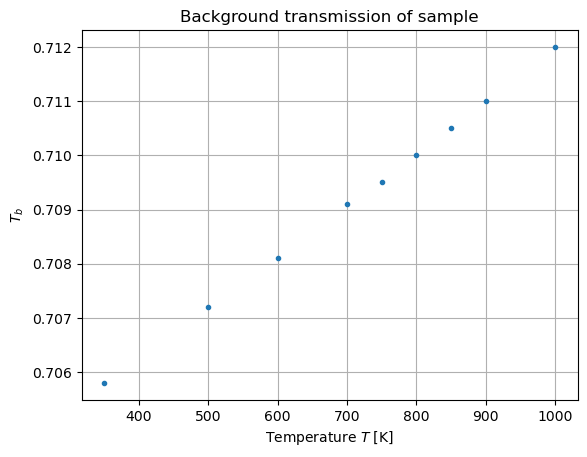

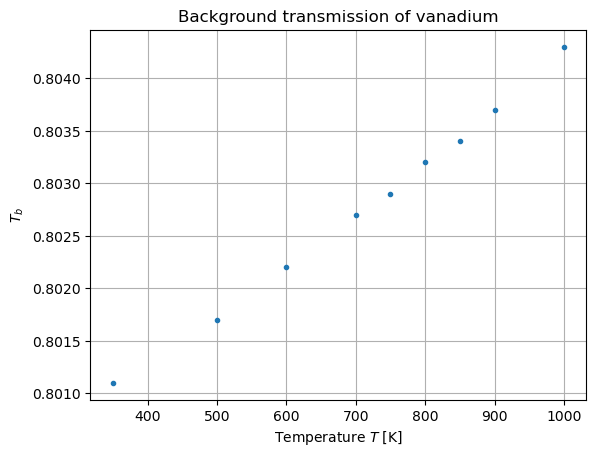

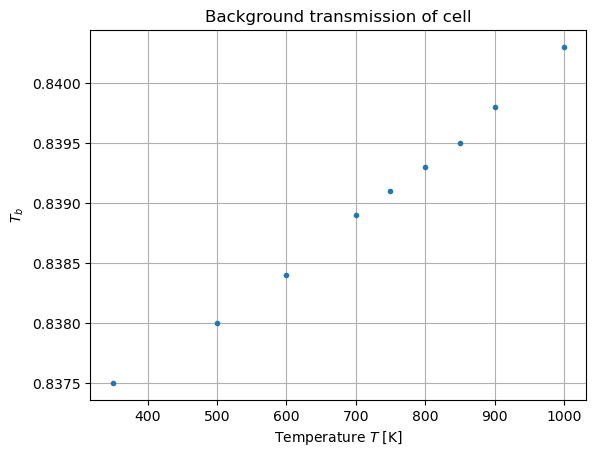

In [13]:

plt.plot(T,trasb_sample,'.')
plt.xlabel(r'Temperature $T$ [K]')
plt.ylabel(r'$T_b$')
plt.title('Background transmission of sample')
plt.grid()
plt.show()


plt.plot(T,trasb_v,'.')
plt.xlabel(r'Temperature $T$ [K]')
plt.ylabel(r'$T_b$')
plt.title('Background transmission of vanadium')
plt.grid()
plt.show()


plt.plot(T,trasb_cell,'.')
plt.xlabel(r'Temperature $T$ [K]')
plt.ylabel(r'$T_b$')
plt.title('Background transmission of cell')
plt.grid()
plt.show()

After having retrieved the transmission factors $T_B$, one is able to calculate the background intensities as
$$
I_B = I_{Cd} + T_B \left(I_{vac}- I_{Cd}\right)
$$

where $I_{vac}$ is the empty furnace intensity and $I_{Cd}$ the Cadmium intensity.

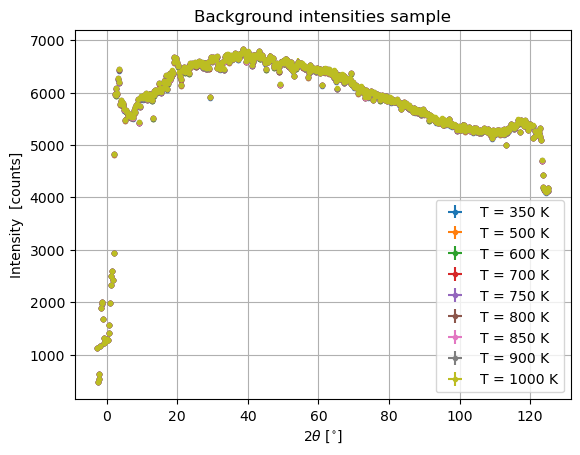

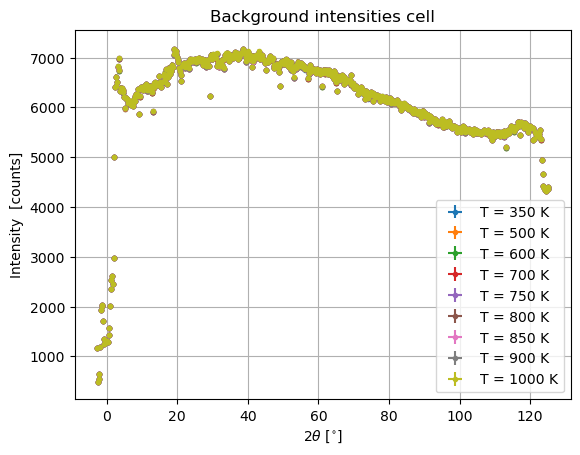

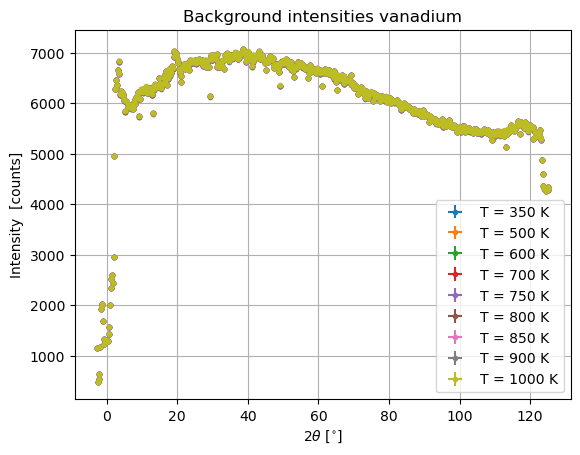

In [14]:
background_sample = []
err_background_sample = []

for i in range(len(T)):
    back = cadmium + trasb_sample[i]*(empty_furnace-cadmium)
    err_back = np.sqrt((err_cadmium*(1-trasb_sample[i]))**2+(trasb_sample[i]*err_empty_furnace)**2)
    background_sample.append(back)
    err_background_sample.append(err_back)
    plt.errorbar(angle,back, fmt = '.', yerr = err_back, xerr= err_angle,label = 'T = %d K' %T[i])
plt.xlabel(r'$2 \theta$ [$^{\circ}$]')
plt.ylabel('Intensity  [counts]')
plt.title('Background intensities sample')
plt.grid()
plt.legend()
plt.show()

background_cell = []
err_background_cell =  []

for i in range(len(T)): 
    back = cadmium + trasb_cell[i]*(empty_furnace-cadmium)
    err_back = np.sqrt((err_cadmium*(1-trasb_cell[i]))**2+(trasb_cell[i]*err_empty_furnace)**2)
    background_cell.append(back)
    err_background_cell.append(err_back)
    plt.errorbar(angle,back, fmt = '.', yerr = err_back, xerr= err_angle,label = 'T = %d K' %T[i])
plt.xlabel(r'$2 \theta$ [$^{\circ}$]')
plt.ylabel('Intensity  [counts]')
plt.title('Background intensities cell')
plt.grid()
plt.legend()
plt.show()

background_v = []
err_background_v = []

for i in range(len(T)):
    back = cadmium + trasb_v[i]*(empty_furnace-cadmium)
    err_back = np.sqrt((err_cadmium*(1-trasb_v[i]))**2+(trasb_v[i]*err_empty_furnace)**2)
    background_v.append(back)
    err_background_v.append(err_back)
    plt.errorbar(angle,back, fmt = '.', yerr = err_back, xerr= err_angle,label = 'T = %d K' %T[i])
plt.xlabel(r'$2 \theta$ [$^{\circ}$]')
plt.ylabel('Intensity  [counts]')
plt.title('Background intensities vanadium')
plt.grid()
plt.legend()
plt.show()

# Cell and multiple scattering

Retrieve $m$, $\gamma$ and $T_m$ with Fortran MULTG.F

In [15]:
def write_line(file_name:str, line:int, content:str):
  line -= 1 # Python starts counting at 0, but people start counting at one. This accounts for that.
  with open(file_name, "r") as file: # Open the file in read mode
    lines = file.readlines() # Assign the file as a list to a variable
    lines[line] = content + "\n" # Replace the proper line with the provided content
  with open(file_name, "w") as file: # Open the file in write mode
    file.write("".join(lines)) # Write the modified content to the file

Define number of extarctions (see /Multg/MULTG_stability.ipynb to select it) and angle mesh

In [16]:
NEST = 2e5   # number of extractions
angle_m = np.linspace(-4,126,14)
print(angle_m)

data_folder = Path("/home/simo/Scrivania/Thesis/Multg/")
name = 'FORT4'
file_to_open = data_folder / name
write_line(file_to_open,7,str(NEST))   # select NEST
write_line(file_to_open,9, str(len(angle_m))+'.')
for i in range(len(angle_m)):
    write_line(file_to_open,10+i,str(angle_m[i]))

[ -4.   6.  16.  26.  36.  46.  56.  66.  76.  86.  96. 106. 116. 126.]


M e Trasm sample and gamma (numeratro of gamma)

In [26]:
gamma = []
m_sample = []
m_v = []
trasm_sample = []
trasm_v = []

os.chdir(r"/home/simo/Scrivania/Thesis/Multg")
name = 'OUTPUT'
code_file = 'MULTG.F'

file_to_change = data_folder / code_file

for i in range(len(T)):
    print('### T = %8.0f K ###' %T[i])
    write_line(file_to_open,3,'0.4       '+ str(mu_geo2_s[i])+'    '+str(mu_geo2_a[i]))
    write_line(file_to_open,5,'0.55      '+ str(mu_v_s[i])+'    '+str(mu_v_a[i]))
    write_line(file_to_change,225, '      IF(I.EQ.3)WRITE(5,222, ADVANCE=\'NO\')TRAS')

    proc = subprocess.Popen(["gfortran -o MULTG MULTG.F && ./MULTG"], shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

    output =  proc.communicate()[0]
    
    Tm = read_dat_file(name,1)[1]
    m = read_dat_file(name,1)[2]
    g = read_dat_file(name,1)[3]

    trasm_sample.append(Tm)
    m_sample.append(m)
    gamma.append(g)


### T =      350 K ###
### T =      500 K ###
### T =      600 K ###
### T =      700 K ###
### T =      750 K ###
### T =      800 K ###
### T =      850 K ###
### T =      900 K ###
### T =     1000 K ###


M e trasm vandium

In [27]:

for i in range(len(T)):
    print('### T = %8.0f ### K' %T[i])
    write_line(file_to_open,3,'0.4       '+ str(mu_v_s[i])+'    '+str(mu_v_a[i]))
    write_line(file_to_open,5,'0.55      0.0       0.0')
    write_line(file_to_change,225, '      IF(I.EQ.1)WRITE(5,222, ADVANCE=\'NO\')TRAS')

    proc = subprocess.Popen(["gfortran -o MULTG MULTG.F && ./MULTG"], shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

    output =  proc.communicate()[0]
    
    Tm = read_dat_file(name,1)[1]
    m = read_dat_file(name,1)[2]

    trasm_v.append(Tm)
    m_v.append(m)

### T =      350 ### K
### T =      500 ### K
### T =      600 ### K
### T =      700 ### K
### T =      750 ### K
### T =      800 ### K
### T =      850 ### K
### T =      900 ### K
### T =     1000 ### K


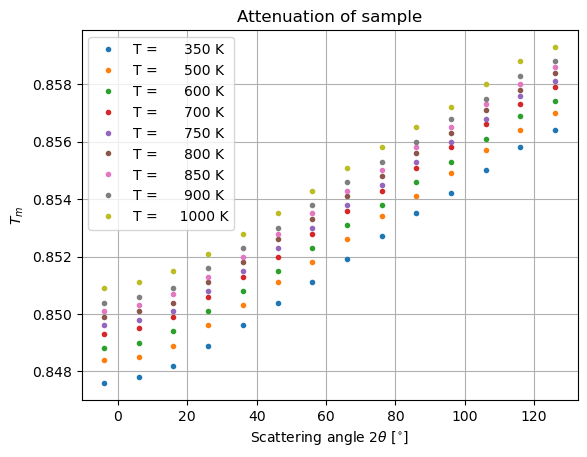

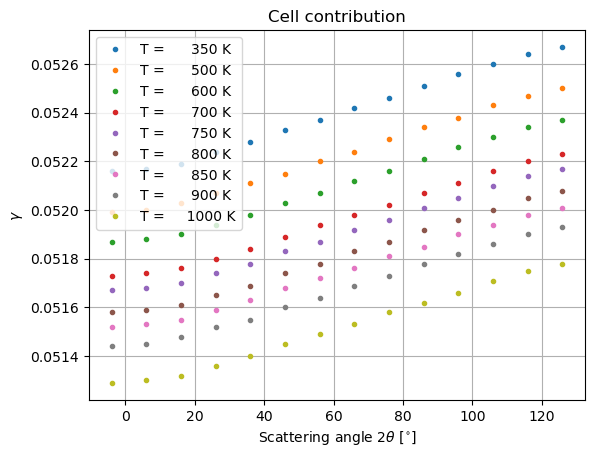

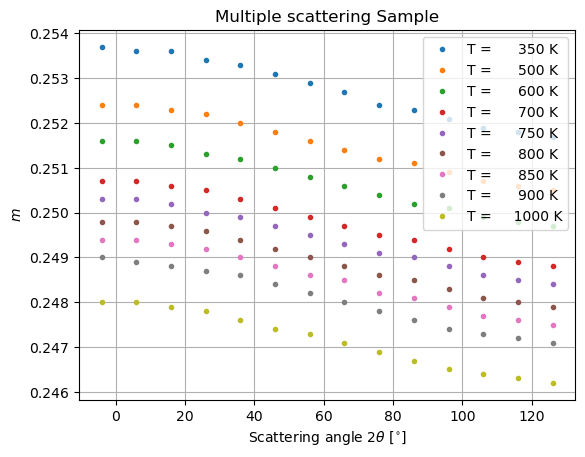

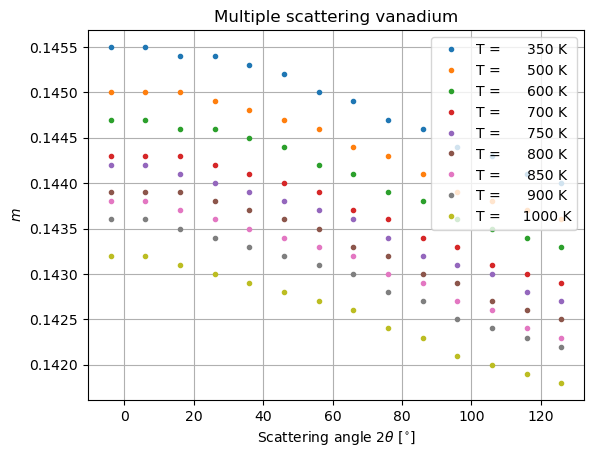

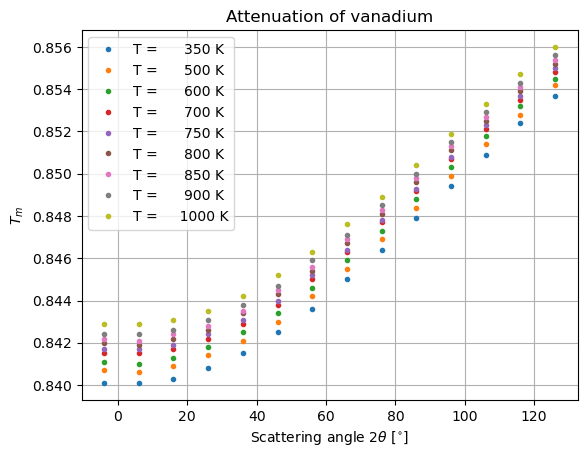

In [28]:
for i in range(len(T)):
    plt.plot(angle_m,trasm_sample[i],'.',label= 'T = %8.0f K' %T[i])
    plt.xlabel(r'Scattering angle $2 \theta$ [$^{\circ}$]')
    plt.ylabel(r'$T_m$')
    plt.title('Attenuation of sample')
    plt.grid()
    plt.legend()
plt.show()

for i in range(len(T)):
    plt.plot(angle_m,gamma[i],'.',label= 'T = %8.0f K' %T[i])
    plt.xlabel(r'Scattering angle $2 \theta$ [$^{\circ}$]')
    plt.ylabel(r'$\gamma$')
    plt.title('Cell contribution')
    plt.grid()
    plt.legend()
plt.show()

for i in range(len(T)):
    '''p0=[max(m_sample[i])-min(m_sample[i]),0,120,min(m_sample[i])]
    popt,pcov = curve_fit(gaussian_baseline,angle_m,m_sample[i],p0=p0,maxfev=80000)
   # m_sample_fit.append(quadratic(q,*popt))
    chi_sq = np.sum((m_sample[i]-gaussian_baseline(angle_m, *popt))**2/(1e-4/np.sqrt(12))**2)/(np.size(m_sample[i])-4)
    print('Fit to gausssian function a*exp(-(theta-theta0)^2/2*sigma^2)+b')
    par = my_round(popt,np.sqrt(np.diag(pcov)))
    print('a', par[0][0], '+/-', par[0][1])
    print('theta0', par[1][0], '+/-', par[1][1])
    print('sigma', par[2][0], '+/-', par[2][1])
    print('b', par[3][0], '+/-', par[3][1])
    print('Chi square', chi_sq)
    plt.plot(angle,gaussian_baseline(angle,*popt),label = 'Fit %8.0f K' % T[i])'''
    plt.plot(angle_m,m_sample[i],'.',label= 'T = %8.0f K' %T[i])
    plt.xlabel(r'Scattering angle $2 \theta$ [$^{\circ}$]')
    plt.ylabel(r'$m$')
    plt.title('Multiple scattering Sample')
    plt.legend()
    plt.grid()
plt.show()

for i in range(len(T)):
    '''p0=[max(m_v[i])-min(m_v[i]),0,120,min(m_v[i])]
    popt,pcov = curve_fit(gaussian_baseline,angle_m,m_v[i],p0=p0,maxfev=80000)
   # m_sample_fit.append(quadratic(q,*popt))
    chi_sq = np.sum((m_v[i]-gaussian_baseline(angle_m, *popt))**2/(1e-4/np.sqrt(12))**2)/(np.size(m_v[i])-4)
    print('Fit to gausssian function a*exp(-(theta-theta0)^2/2*sigma^2)+b')
    par = my_round(popt,np.sqrt(np.diag(pcov)))
    print('a', par[0][0], '+/-', par[0][1])
    print('theta0', par[1][0], '+/-', par[1][1])
    print('sigma', par[2][0], '+/-', par[2][1])
    print('b', par[3][0], '+/-', par[3][1])
    print('Chi square', chi_sq)
    plt.plot(angle,gaussian_baseline(angle,*popt),label = 'Fit %8.0f K' % T[i])'''
    plt.plot(angle_m,m_v[i],'.',label= 'T = %8.0f K' %T[i])
    plt.xlabel(r'Scattering angle $2 \theta$ [$^{\circ}$]')
    plt.ylabel(r'$m$')
    plt.title('Multiple scattering vanadium')
    plt.legend()
    plt.grid()
plt.show()

for i in range(len(T)):
    plt.plot(angle_m,trasm_v[i],'.',label= 'T = %8.0f K' %T[i])
    plt.xlabel(r'Scattering angle $2 \theta$ [$^{\circ}$]')
    plt.ylabel(r'$T_m$')
    plt.title('Attenuation of vanadium')
    plt.legend()
    plt.grid()
plt.show()


Try to fit $m$ with gausssian to retrieve $Q \longrightarrow \infty$ behaviour

In [ ]:
'''m_sample_fit = []
err_m_sample_fit = []

m_v_fit = []
err_m_v_fit = []

for i in range(len(T)):
    p0=[max(m_sample[i])-min(m_sample[i]),120,min(m_sample[i])]
    popt,pcov = curve_fit(gaussian_zero,angle_m,m_sample[i],p0=p0,maxfev=80000)
    m_sample_fit.append(popt[2])
    err_m_sample_fit.append(np.sqrt(pcov[2][2]))
    chi_sq = np.sum((m_sample[i]-gaussian_zero(angle_m, *popt))**2/(1e-4/np.sqrt(12))**2)/(np.size(m_sample[i])-3)
    print('Fit to gausssian function a*exp(-theta^2/2*sigma^2)+b')
    par = my_round(popt,np.sqrt(np.diag(pcov)))
    print('a', par[0][0], '+/-', par[0][1])
    print('sigma', par[1][0], '+/-', par[1][1])
    print('b', par[2][0], '+/-', par[2][1])
    print('Chi square', chi_sq)
    plt.plot(angle,gaussian_zero(angle,*popt),label = 'Fit %8.0f K' % T[i])
    plt.plot(angle_m,m_sample[i],'.',label= 'T = %8.0f K' %T[i])
    plt.xlabel(r'Scattering angle $2 \theta$ [$^{\circ}$]')
    plt.ylabel(r'$m$')
    plt.title('Multiple scattering Sample')
    plt.legend()
    plt.grid()
plt.show()

for i in range(len(T)):
    p0=[max(m_v[i])-min(m_v[i]),120,min(m_v[i])]
    popt,pcov = curve_fit(gaussian_zero,angle_m,m_v[i],p0=p0,maxfev=80000)
    m_v_fit.append(popt[2])
    err_m_v_fit.append(np.sqrt(pcov[2][2]))
    chi_sq = np.sum((m_v[i]-gaussian_zero(angle_m, *popt))**2/(1e-4/np.sqrt(12))**2)/(np.size(m_v[i])-3)
    print('Fit to gausssian function a*exp(-theta^2/2*sigma^2)+b')
    par = my_round(popt,np.sqrt(np.diag(pcov)))
    print('a', par[0][0], '+/-', par[0][1])
    print('sigma', par[1][0], '+/-', par[1][1])
    print('b', par[2][0], '+/-', par[2][1])
    print('Chi square', chi_sq)
    plt.plot(angle,gaussian_zero(angle,*popt),label = 'Fit %8.0f K' % T[i])
    plt.plot(angle_m,m_v[i],'.',label= 'T = %8.0f K' %T[i])
    plt.xlabel(r'Scattering angle $2 \theta$ [$^{\circ}$]')
    plt.ylabel(r'$m$')
    plt.title('Multiple scattering vanadium')
    plt.legend()
    plt.grid()
plt.show()'''

"m_sample_fit = []\nerr_m_sample_fit = []\n\nm_v_fit = []\nerr_m_v_fit = []\n\nfor i in range(len(T)):\n    p0=[max(m_sample[i])-min(m_sample[i]),120,min(m_sample[i])]\n    popt,pcov = curve_fit(gaussian_zero,angle_m,m_sample[i],p0=p0,maxfev=80000)\n    m_sample_fit.append(popt[2])\n    err_m_sample_fit.append(np.sqrt(pcov[2][2]))\n    chi_sq = np.sum((m_sample[i]-gaussian_zero(angle_m, *popt))**2/(1e-4/np.sqrt(12))**2)/(np.size(m_sample[i])-3)\n    print('Fit to gausssian function a*exp(-theta^2/2*sigma^2)+b')\n    par = my_round(popt,np.sqrt(np.diag(pcov)))\n    print('a', par[0][0], '+/-', par[0][1])\n    print('sigma', par[1][0], '+/-', par[1][1])\n    print('b', par[2][0], '+/-', par[2][1])\n    print('Chi square', chi_sq)\n    plt.plot(angle,gaussian_zero(angle,*popt),label = 'Fit %8.0f K' % T[i])\n    plt.plot(angle_m,m_sample[i],'.',label= 'T = %8.0f K' %T[i])\n    plt.xlabel(r'Scattering angle $2 \theta$ [$^{\\circ}$]')\n    plt.ylabel(r'$m$')\n    plt.title('Multiple scatteri

Interpolate gamma and trasm values

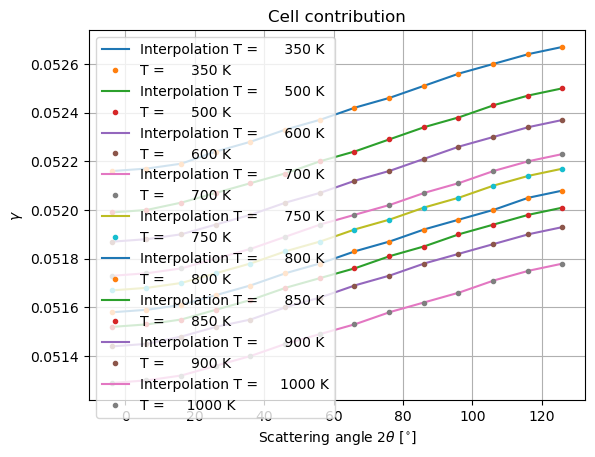

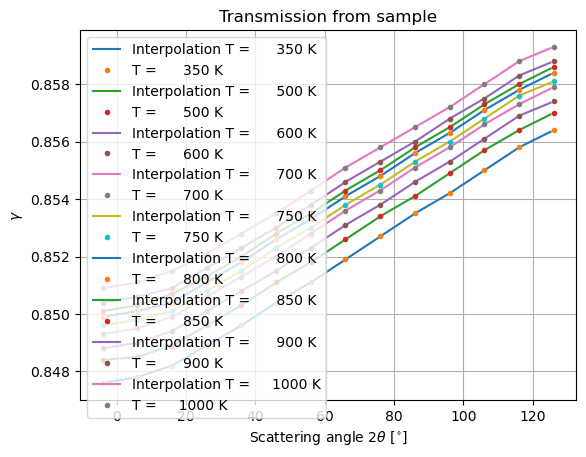

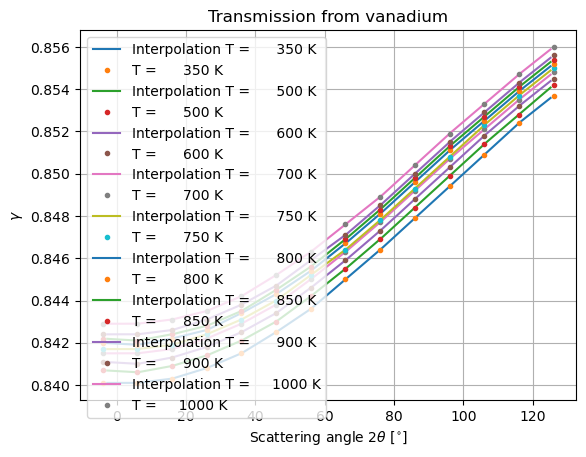

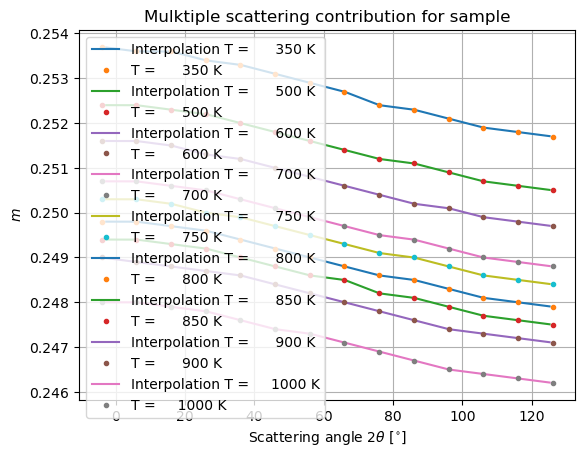

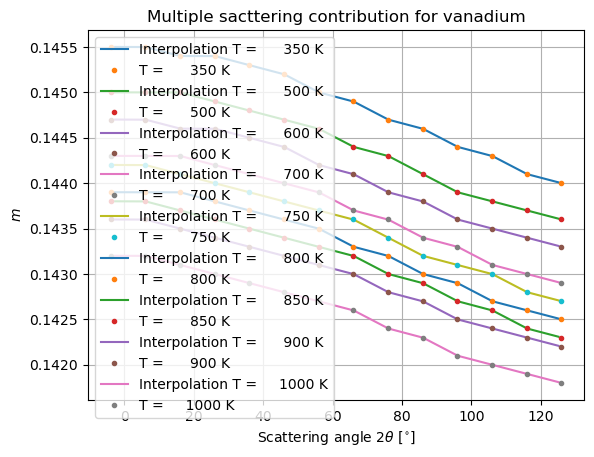

In [29]:
gamma_interp = []
trasm_sample_interp = []
trasm_v_interp = []
m_sample_interp = []
m_v_interp = []

for i in range(len(T)):
    gamma_interp.append(sci.interpolate.griddata(angle_m,gamma[i],angle))
    trasm_sample_interp.append(sci.interpolate.griddata(angle_m,trasm_sample[i],angle))
    trasm_v_interp.append(sci.interpolate.griddata(angle_m,trasm_v[i],angle))
    m_sample_interp.append(sci.interpolate.griddata(angle_m,m_sample[i],angle))
    m_v_interp.append(sci.interpolate.griddata(angle_m,m_v[i],angle))
gamma_interp = np.array(gamma_interp)
trasm_sample_interp = np.array(trasm_sample_interp)
trasm_v_interp = np.array(trasm_v_interp)
m_sample_interp = np.array(m_sample_interp)
m_v_interp = np.array(m_v_interp)

for i in range(len(T)):
    plt.plot(angle,gamma_interp[i], label =  'Interpolation T = %8.0f K' %T[i] )
    plt.plot(angle_m,gamma[i],'.',label= 'T = %8.0f K' %T[i])
    plt.xlabel(r'Scattering angle $2 \theta$ [$^{\circ}$]')
    plt.ylabel(r'$\gamma$')
    plt.title('Cell contribution')
    plt.grid()
    plt.legend()
plt.show()


for i in range(len(T)):
    plt.plot(angle,trasm_sample_interp[i], label =  'Interpolation T = %8.0f K' %T[i] )
    plt.plot(angle_m,trasm_sample[i],'.',label= 'T = %8.0f K' %T[i])
    plt.xlabel(r'Scattering angle $2 \theta$ [$^{\circ}$]')
    plt.ylabel(r'$\gamma$')
    plt.title('Transmission from sample')
    plt.grid()
    plt.legend()
plt.show()


for i in range(len(T)):
    plt.plot(angle,trasm_v_interp[i], label =  'Interpolation T = %8.0f K' %T[i] )
    plt.plot(angle_m,trasm_v[i],'.',label= 'T = %8.0f K' %T[i])
    plt.xlabel(r'Scattering angle $2 \theta$ [$^{\circ}$]')
    plt.ylabel(r'$\gamma$')
    plt.title('Transmission from vanadium')
    plt.grid()
    plt.legend()
plt.show()

for i in range(len(T)):
    plt.plot(angle,m_sample_interp[i], label =  'Interpolation T = %8.0f K' %T[i] )
    plt.plot(angle_m,m_sample[i],'.',label= 'T = %8.0f K' %T[i])
    plt.xlabel(r'Scattering angle $2 \theta$ [$^{\circ}$]')
    plt.ylabel(r'$m$')
    plt.title('Mulktiple scattering contribution for sample')
    plt.grid()
    plt.legend()
plt.show()

for i in range(len(T)):
    plt.plot(angle,m_v_interp[i], label =  'Interpolation T = %8.0f K' %T[i] )
    plt.plot(angle_m,m_v[i],'.',label= 'T = %8.0f K' %T[i])
    plt.xlabel(r'Scattering angle $2 \theta$ [$^{\circ}$]')
    plt.ylabel(r'$m$')
    plt.title('Multiple sacttering contribution for vanadium')
    plt.grid()
    plt.legend()
plt.show()



# Single scattering intensity form sample and vanadium

In [30]:
I_s = []
I_v = []

I_sample = np.array(sample) - np.array(background_sample) - gamma_interp*np.array(empty_cell_800K -background_cell)
I_vanadium = np.array(vanadium) - np.array(background_v)
index = get_indices_in_range(angle,100,angle[-1])

for i in range(len(T)):
    
    I_m =  np.mean(m_sample_interp[i][index[0]:index[-1]]/(m_sample_interp[i][index[0]:index[-1]]+1)*I_sample[i][index[0]:index[-1]])
    I = I_sample[i] - I_m
    I_s.append(I)

    I_m =  np.mean(m_v_interp[i][index[0]:index[-1]]/(m_v_interp[i][index[0]:index[-1]]+1)*I_vanadium[i][index[0]:index[-1]])
    I = I_vanadium[i] - I_m
    I_v.append(I)
I_s=np.array(I_s)
I_v=np.array(I_v)

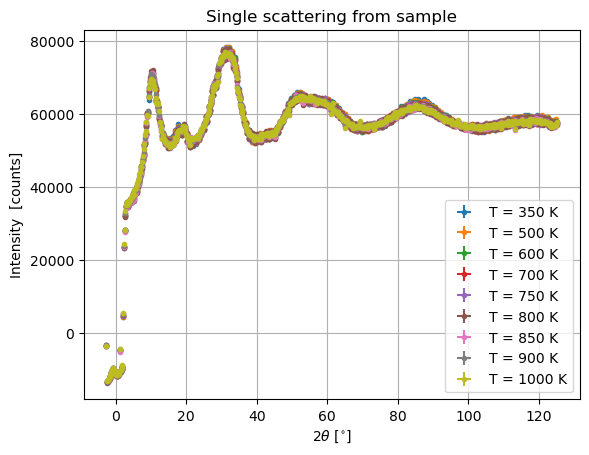

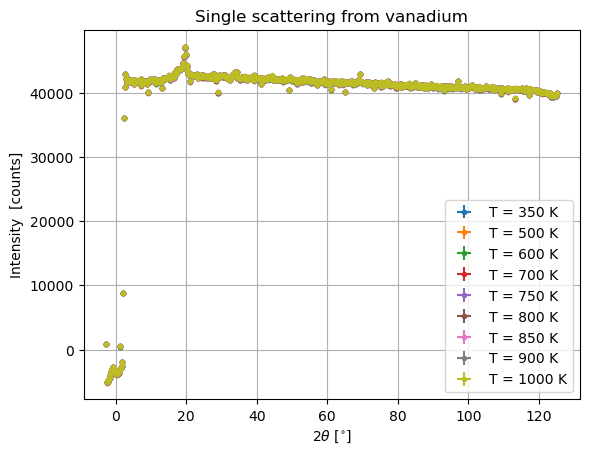

In [31]:
for i in range(len(T)):
    plt.errorbar(angle,I_s[i], fmt = '.', yerr = 0, xerr= err_angle,label = 'T = %d K' %T[i])
plt.xlabel(r'$2 \theta$ [$^{\circ}$]')
plt.ylabel('Intensity  [counts]')
plt.title('Single scattering from sample')
plt.grid()
plt.legend()
plt.show()

for i in range(len(T)):
    plt.errorbar(angle,I_v[i], fmt = '.', yerr = 0, xerr= err_angle,label = 'T = %d K' %T[i])
plt.xlabel(r'$2 \theta$ [$^{\circ}$]')
plt.ylabel('Intensity  [counts]')
plt.title('Single scattering from vanadium')
plt.grid()
plt.legend()
plt.show()

# Normalize to vanadium standard and get $S(Q)$

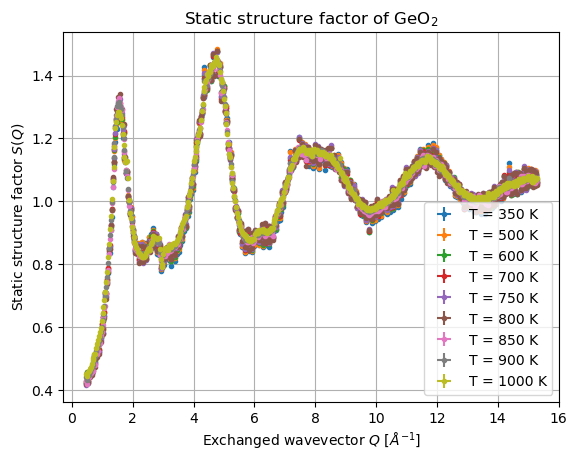

In [32]:
Sdq = []
angle_init = 3
index = get_indices_in_range(angle, angle_init,angle_init+0.2)[0]

angle_cut = angle[index:]
q_cut = q[index:]

for i in range(len(T)):
    sdq = I_s[i][index:]*trasm_v_interp[i][index:]*sigma_v_s*n_v[i]/(n_geo2[i]*sigma_geo2_coh*I_v[i][index:]*trasm_sample_interp[i][index:])-(w_ge*(sigma_ge_inc+sigma_ge_coh)+w_o*sigma_o_coh)/sigma_geo2_coh
    Sdq.append(sdq)
    #plt.errorbar(angle_cut,sdq, fmt = '.', yerr = 0, xerr= err_angle,label = 'T = %d K' %T[i])
    plt.errorbar(q_cut,sdq, fmt = '.', yerr = 0, xerr= err_angle,label = 'T = %d K' %T[i])
#plt.xlabel(r'$2 \theta$ [$^{\circ}$]')
plt.xlabel(r'Exchanged wavevector $Q$ [$\AA^{-1}$]')
plt.ylabel('Static structure factor $S(Q)$')
plt.title(r'Static structure factor of GeO$_2$')
plt.grid()
plt.legend()
plt.show()
